In [1]:
from DataFetcher import DataFetcher
from USTs import USTs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import pandas_datareader.data as web

In [2]:
auctions = DataFetcher().fetch_auction_data()
prices = DataFetcher().fetch_historical_UST_data(date=datetime.datetime(year=2025, month=6, day=26))

In [3]:
ust_set = USTs(auction_data=auctions, price_data=prices)
ust_set = ust_set.get_current_UST_set(settlement_date=datetime.date(2025, 6, 27),
                                      get_ytms=True, include_FRNs=False, include_TIPS=False)

In [4]:
ust_set

,Cusip,Security type,Rate,Maturity date,Buy,Sell,End of day,Original security term,Issue date,Currently outstanding
0,912797PN1,Bill,0.000,2025-08-14,99.414722,99.413361,99.426667,26-Week,2025-07-03,1.610240e+11
1,912797MS3,Bill,0.000,2025-10-02,98.862111,98.859389,98.871028,52-Week,2025-07-03,1.233190e+11
2,912797QU4,Bill,0.000,2025-09-16,99.046750,99.043333,99.048250,17-Week,2025-07-01,6.019300e+10
3,912797QC4,Bill,0.000,2025-07-29,99.631500,99.630583,99.641778,17-Week,2025-07-01,1.254450e+11
4,912797QL4,Bill,0.000,2025-08-26,99.267153,99.264611,99.280000,17-Week,2025-07-01,6.019500e+10
...,...,...,...,...,...,...,...,...,...,...
452,912810EZ7,Bond,6.625,2027-02-15,104.812500,104.500000,104.625000,30-Year,1997-02-18,NaN
453,912810EY0,Bond,6.500,2026-11-15,103.968750,103.718750,103.656250,30-Year,1996-11-15,NaN
454,912810EX2,Bond,6.750,2026-08-15,103.265625,102.968750,103.031250,30-Year,1996-08-15,NaN
455,912810EW4,Bond,6.000,2026-02-15,101.265625,100.968750,101.031250,30-Year,1996-02-15,NaN


In [5]:
auctions.sort_values(by='Issue date', inplace=True ,ascending=False)
auctions.drop_duplicates(subset=['Cusip'], keep='first', inplace=True)

In [6]:
a = pd.merge(prices, auctions, on='Cusip', how='inner')
a = a[(a['Security type'] != 'FRN') & (a['Security type'] != 'TIPS')]

In [7]:
filtered_ust_set = ust_set.copy()
filtered_ust_set['Days to maturity'] = (filtered_ust_set['Maturity date'] - pd.to_datetime('today')).dt.days
filtered_ust_set = filtered_ust_set[filtered_ust_set['Days to maturity'] > 90]
sns.relplot(x='Maturity date', y='EOD YTM', hue='Security type', data=filtered_ust_set, kind='scatter', height=6, aspect=2)

ValueError: Could not interpret value `EOD YTM` for `y`. An entry with this name does not appear in `data`.

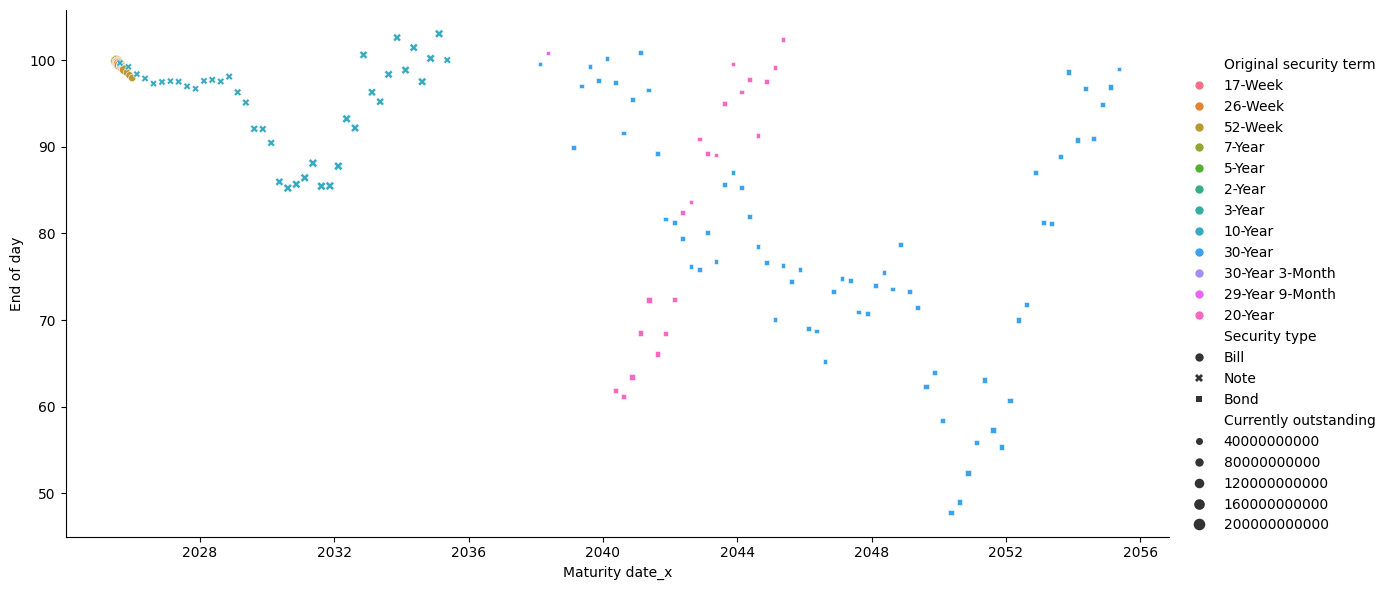

In [ ]:
sns.relplot(data=a, x='Maturity date_x', y='End of day', hue='Original security term',
            style='Security type', kind='scatter', height=6, aspect=2, size='Currently outstanding')